# Trabajo Práctico 2: Análisis con KNN

**Alumnos y padron:**

Izquierdo Osorio, Stephanie. 104196 

Rosas, Martin Alejandro. 98535

---

## Preparación del entorno

In [1]:
import pandas as pd
import numpy as np

from preprocessing import *
from charts_and_write import *

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

## Carga y preparación del set de datos

In [2]:
download_raw_data()

Aplicamos un procesamiento para pasar las variables categoricas a numericas

In [3]:
X_data = pd.read_csv("impuestos_train.cvs")
X_holdout= pd.read_csv("impuestos_holdout.cvs")

X_data, X_holdout= prepare_existing_data(X_data, X_holdout)

## KNN

KNN es un método de aprendizaje supervisado que consiste en predecir la clase de una instancia en base a sus vecinos.

Para el procesamiento de los datos, decidimos primero realizar la conversión a variables categóricas mediante OneHotEncoding de las variables detectadas en la primera parte del trabajo. En una segunda version se le aplica a los datos en este método una normalización, de forma tal de que algún feature no tenga demasiado peso, cosa que puede afectar a las distancias al momento de calcularlas y en la ultima version se utiliza un encodeo numerico y en una tercera version se normalizaran los valores.

## Hiperparametros

Comenzamos buscando los mejores hiperparametros para nuestro modelo de KNN

Consideramos que los mas relevantes son los siguientes:

- **K**: Determina la cantidad de vecinos para una instancia. Comenzamos evaluando con cantidades bajas y lo vamos aumentando hasta tener una cantidad mayor.

- **Peso**: Este es el peso que se le da a las distancias entre los puntos. Analizamos con 'uniform' (Todas las distancias valen lo mismo), y con 'distance' (Pesa a los puntos con la inversa de la distancia, mientras mas cerca, mas valor tenes).

- **Metrica**: Es la forma en que se va a calcular la distancia. Se eligieron varias de forma aleatoria de la lista que tiene sklearn.

In [4]:
grid_parameters = {
    'n_neighbors' : [2,3,4,5,6,7,8,9,10,15,20],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski', 'euclidean', 'manhatan']
}

### Version 1

In [5]:
columns_to_encode = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero", "relacion_de_dependencia"]
X_data_1 = encode_one_hot(X_data, columns_to_encode)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_data_1.drop(columns={"tiene_alto_valor_adquisitivo"}), X_data_1["tiene_alto_valor_adquisitivo"], random_state=42)

In [7]:
model_Knn_1 = KNeighborsClassifier(n_neighbors=5)
gsvc_1 = GridSearchCV(model_Knn_1, grid_parameters, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')
gs_1_results = gsvc_1.fit(X_train, y_train)
gs_1_results.best_params_

Fitting 5 folds for each of 66 candidates, totalling 330 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:  2.5min finished


{'metric': 'minkowski', 'n_neighbors': 20, 'weights': 'uniform'}

Con gridSearch obtuvimos que los mejores hiperparamentros son n=20, con peso uniforme y con una metrica minkowski.
Procedemos a hacer el modelo con estos hiperparametros

In [8]:
knn_1 = KNeighborsClassifier(n_neighbors=20, weights = 'uniform', metric='minkowski')

In [9]:
knn_1.fit(X_train, y_train)
y_pred = knn_1.predict(X_test)

#### Evaluacion

In [10]:
show_metrics(knn_1, y_pred, y_test, X_test, "KNN 1")

Accuracy: 0.8562830119149981
----------------------------------------------
Precision: 0.5910742086144266
----------------------------------------------
Recall: 0.7488494411571335
----------------------------------------------
F1_score: 0.6606728538283063
----------------------------------------------
AUC-ROC score para KNN 1: 0.902


Observamos que para este primer preprocesamiento accuracy y recall dieron bien y precision dio mas bajo, vamos a ver si con los proximos preprocesamientos esto mejora. De todas formas este preprocesamiento **No** normalizo los datos, por ende no seria del todo correcto usarlo ya que sabemos que al no estar normalizado influye su valor en el calculo de pesos/distancias.

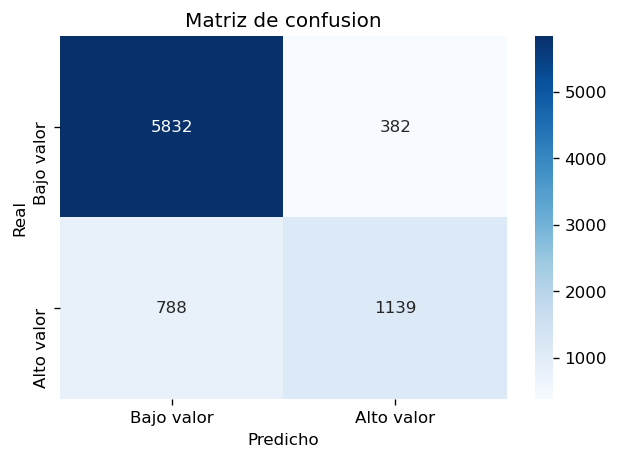

In [11]:
show_confusion_matrix(y_pred,y_test)

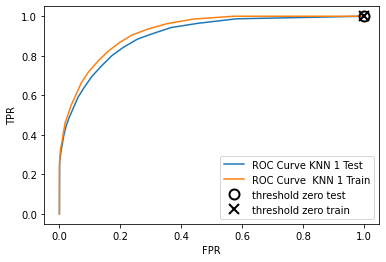

In [13]:
show_roc_curve(knn_1,"KNN 1",X_test, X_train, y_test, y_train)

### Version 2: Normalizacion de datos

In [7]:
X_train_normalize = normalize_columns(X_train)
X_test_normalize = normalize_columns(X_test)


In [8]:
model_Knn_2 = KNeighborsClassifier(n_neighbors=5)
gsvc_2 = GridSearchCV(model_Knn_2, grid_parameters, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc', return_train_score=True)
gs_2_results = gsvc_2.fit(X_train_normalize, y_train)
gs_2_results.best_params_

Fitting 5 folds for each of 66 candidates, totalling 330 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:  4.9min finished


{'metric': 'minkowski', 'n_neighbors': 20, 'weights': 'uniform'}

Obtuvimos los mismos hiperparametros que en la version anterior

In [16]:
knn_2 = KNeighborsClassifier(n_neighbors = 20, weights = 'uniform', metric='minkowski')
knn_2.fit(X_train_normalize, y_train)
y_pred_2 = knn_2.predict(X_test_normalize)

#### Evaluacion

In [17]:
show_metrics(knn_2, y_pred_2, y_test, X_test_normalize, "KNN 2")


Accuracy: 0.8293821397862671
----------------------------------------------
Precision: 0.5568240788790867
----------------------------------------------
Recall: 0.6672885572139303
----------------------------------------------
F1_score: 0.6070721357850071
----------------------------------------------
AUC-ROC score para KNN 2: 0.870


Podemos observar que todas las metricas disminuyeron, sin embargo este preprocesamiento es mas correcto que el anterior y nos esta dando algo mas certero y fiel a los datos que tenemos

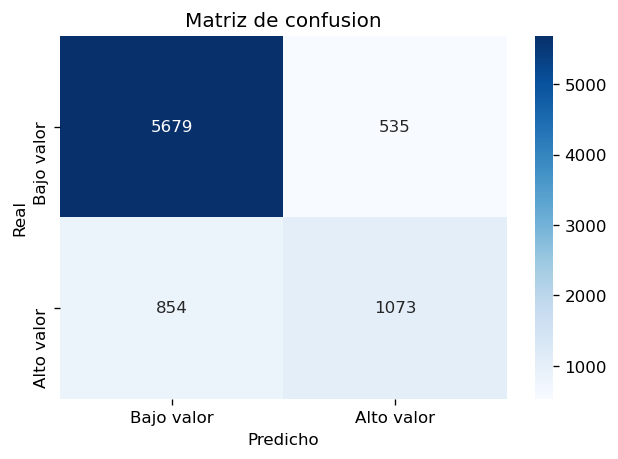

In [18]:
show_confusion_matrix(y_pred_2, y_test)

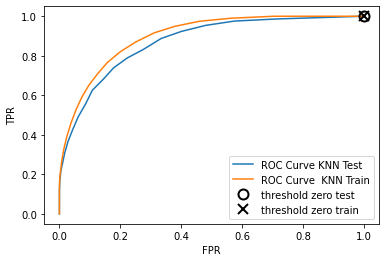

In [20]:
show_roc_curve(knn_2, "KNN", X_test_normalize, X_train_normalize, y_test, y_train)

## Preprocesamiento version 3 

Agregamos ahora un nuevo encodeo numerico y normalizamos las columnas

In [10]:
columns_to_sort = ["educacion", "edad", "bolsa"]
X_data_3 = encoding_sorted(X_data_1, columns_to_sort)

In [11]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_data_3.drop(columns={"tiene_alto_valor_adquisitivo"}), X_data_3["tiene_alto_valor_adquisitivo"], random_state=42)

In [13]:
X_train_3 = normalize_columns(X_train_3)
X_test_3 = normalize_columns(X_test_3)

In [14]:
model_Knn_3 = KNeighborsClassifier(n_neighbors=5)
gsvc_3 = GridSearchCV(model_Knn_3, grid_parameters, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')
gs3_results = gsvc_3.fit(X_train_3, y_train_3)
gs3_results.best_params_

Fitting 5 folds for each of 66 candidates, totalling 330 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:  1.8min finished


{'metric': 'minkowski', 'n_neighbors': 20, 'weights': 'uniform'}

Con este nuevo preprocesamiento obtuvimos que la cantidad de vecinos mas apropiada es 10

In [15]:
knn_3 = KNeighborsClassifier(n_neighbors= 20, weights = 'uniform', metric='minkowski')
knn_3.fit(X_train_3, y_train_3)
y_pred_3 = knn_3.predict(X_test_3)

#### evaluacion

In [17]:
show_metrics(knn_3, y_pred_3, y_test_3, X_test_3, "KNN 3")

Accuracy: 0.8468247144085493
----------------------------------------------
Precision: 0.580176440062273
----------------------------------------------
Recall: 0.718508997429306
----------------------------------------------
F1_score: 0.6419753086419754
----------------------------------------------
AUC-ROC score para KNN 3: 0.888


Podemos observar que respecto a la primera version mejoró pero los datos no estan normalizados y es por esto que no podemos usarlo

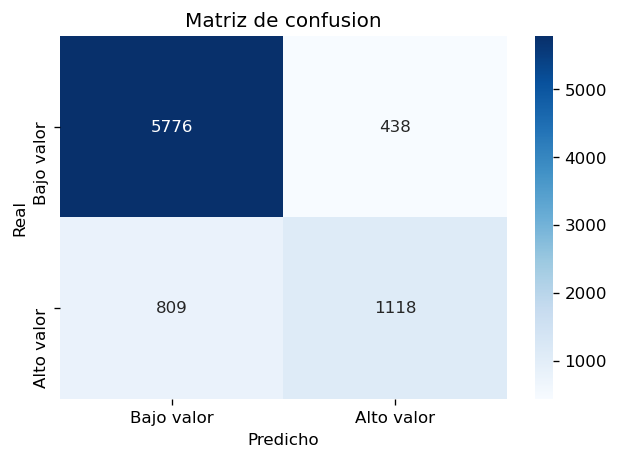

In [18]:
show_confusion_matrix(y_pred_3,y_test_3)

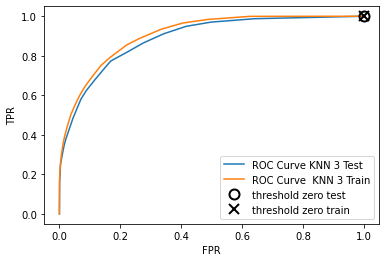

In [19]:
show_roc_curve(knn_3, "KNN 3", X_test_3, X_train_3, y_test_3, y_train_3)

## Predicción

Como pudimos observar anteriormente, el ultimo preprocesamiento fue el mejor y el más indicado. Lo aplicamos para hacer la nueva prediccion

In [20]:
columns_to_encode = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero", "relacion_de_dependencia"]
X_holdout = encode_one_hot(X_holdout, columns_to_encode)
X_holdout = encoding_sorted(X_holdout, columns_to_sort)

ids = np.array(X_holdout['id'])
X_holdout.drop(columns='id', inplace=True)

X_holdout_normalize = normalize_columns(X_holdout)

In [21]:
predictions_holdout = knn_3.predict(X_holdout_normalize)


In [22]:
write_predictions(predictions_holdout, "KNN", ids)